In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:00<00:00, 43.3MB/s]
100% 2.29G/2.29G [01:00<00:00, 40.9MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import  load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
normal_imgs =  [os.path.join( "/content/chest_xray/train/NORMAL", i) for i in os.listdir("/content/chest_xray/train/NORMAL") if i.endswith('.jpeg')]
pneumonia_imgs = [os.path.join("/content/chest_xray/train/PNEUMONIA" , i) for i in os.listdir("/content/chest_xray/train/PNEUMONIA") if i.endswith('.jpeg')]

In [ ]:
print("normal    : ",len(normal_imgs))
print("pneumonia : " ,len(pneumonia_imgs))
print("total     : " , len(pneumonia_imgs) + len(normal_imgs))

normal    :  1341
pneumonia :  3875
total     :  5216


In [ ]:
train_data = []
train_labels = []

for i in normal_imgs:
    train_data.append(i)
    train_labels.append('normal')
for i in pneumonia_imgs:
    train_data.append(i)
    train_labels.append('pneumonia')

df = pd.DataFrame(train_data)
df.columns = ['images']
df['labels'] = train_labels

df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,labels
0,/content/chest_xray/train/PNEUMONIA/person1159...,pneumonia
1,/content/chest_xray/train/PNEUMONIA/person522_...,pneumonia
2,/content/chest_xray/train/PNEUMONIA/person1496...,pneumonia
3,/content/chest_xray/train/PNEUMONIA/person628_...,pneumonia
4,/content/chest_xray/train/PNEUMONIA/person299_...,pneumonia


In [ ]:
df.shape

(5216, 2)

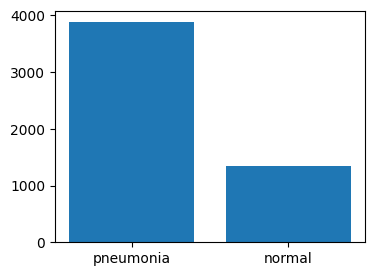

In [ ]:
import seaborn as sns
plt.figure(figsize=(4,3))
plt.bar(df['labels'].value_counts().index,df['labels'].value_counts().values)
plt.show()

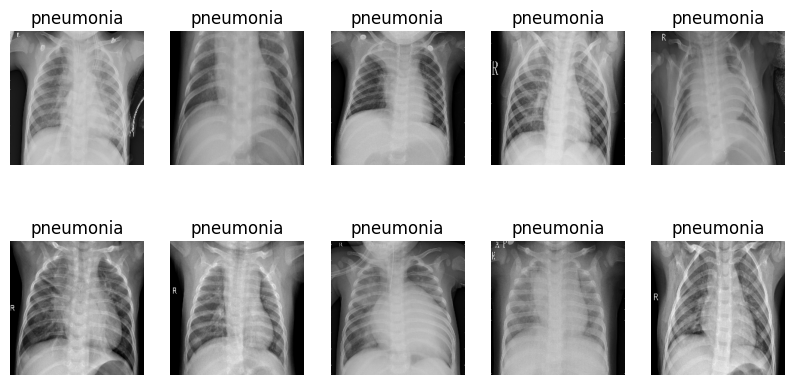

In [ ]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    im = cv2.imread(df['images'][i])
    im = cv2.resize(im , (224,224))
    plt.imshow(im)
    plt.axis('off')
    plt.title(df['labels'][i])
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_gen = ImageDataGenerator(rescale = 1./255.0, shear_range = 0.2 , zoom_range = 0.2 , horizontal_flip  = True , vertical_flip= True , fill_mode = 'nearest')

test_data_gen = ImageDataGenerator(rescale = 1./255.0)

In [ ]:
dt_train = train_data_gen.flow_from_directory("/content/chest_xray/train" , target_size = (224,224) , color_mode = 'rgb',batch_size = 16 , class_mode = 'binary')

dt_val = train_data_gen.flow_from_directory("/content/chest_xray/val" , target_size = (224,224) , color_mode = 'rgb',batch_size = 16 , class_mode = 'binary')

dt_test = test_data_gen.flow_from_directory("/content/chest_xray/test" , target_size = (224,224) , color_mode = 'rgb',batch_size = 16 , class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_ds = tf.data.Dataset.from_generator(
    lambda: dt_train ,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None,]))

dt_traincc = train_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu' , input_shape=(224, 224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64 , activation='relu'))
model.add(Dense(1 , activation='sigmoid'))

In [ ]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer = Adam(lr = 0.0001 , decay = 1e-5), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath='my_model.h5', save_best_only=True)
earlystop = EarlyStopping(patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience = 3, verbose=1)

In [ ]:
history1 = model.fit_generator(dt_train, epochs = 10 , validation_data=dt_val , steps_per_epoch = 5216//16 , class_weight = {0:1.0 , 1:0.4},
                              callbacks = [checkpoint , earlystop , reduce_lr])

Epoch 1/10
326/326 [==============================] - 129s 368ms/step - loss: 0.2401 - accuracy: 0.8200 - val_loss: 0.5525 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/10
326/326 [==============================] - 119s 364ms/step - loss: 0.1465 - accuracy: 0.8917 - val_loss: 0.9314 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/10
326/326 [==============================] - 120s 368ms/step - loss: 0.1275 - accuracy: 0.9059 - val_loss: 0.6217 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/10
326/326 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9070
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
326/326 [==============================] - 120s 366ms/step - loss: 0.1255 - accuracy: 0.9070 - val_loss: 1.0570 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 5/10
326/326 [==============================] - 118s 363ms/step - loss: 0.1036 - accuracy: 0.9248 - val_loss: 1.1375 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 6/10
326/326 [====

In [ ]:
model.evaluate(dt_test ,batch_size = 16)

39/39 [==============================] - 6s 147ms/step - loss: 0.2905 - accuracy: 0.8846


[0.2904718816280365, 0.8846153616905212]

In [ ]:
mm = load_model("/content/my_model.h5")

In [ ]:
mm.evaluate(dt_val)

1/1 [==============================] - 0s 332ms/step - loss: 0.5182 - accuracy: 0.5625


[0.5182445049285889, 0.5625]

In [ ]:
def vgg16_model(num_classes=None):

    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x = Dense(1024, activation='relu')(model.layers[-4].output)# add my own dense Layer after the last conv block
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense (1, activation='sigmoid')(x)

    model = Model(model.input,x)

    return model

In [ ]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:-10]: #freeze all Layers except the last 10
    layer.trainable = False

553467096/553467096 [==============================] - 15s 0us/step


In [ ]:
from keras.optimizers import Adam
vgg_conv.compile(loss='binary_crossentropy', optimizer = Adam(lr = 0.0001 , decay = 1e-5), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath='my_model1.h5', save_best_only=True)
earlystop = EarlyStopping(patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience = 3, verbose=1)

In [ ]:
history2 = vgg_conv.fit_generator(dt_train, epochs = 10, steps_per_epoch= 5216//16 ,
                               validation_data=dt_val , class_weight = {0:1.0 , 1:0.4}, callbacks = [checkpoint , earlystop , reduce_lr])

Epoch 1/10
326/326 [==============================] - 145s 429ms/step - loss: 0.1605 - accuracy: 0.8871 - val_loss: 0.3582 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/10
326/326 [==============================] - 129s 397ms/step - loss: 0.1027 - accuracy: 0.9291 - val_loss: 0.4935 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/10
326/326 [==============================] - 129s 396ms/step - loss: 0.0824 - accuracy: 0.9502 - val_loss: 0.2336 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 4/10
326/326 [==============================] - 128s 393ms/step - loss: 0.0756 - accuracy: 0.9475 - val_loss: 0.1701 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/10
326/326 [==============================] - 126s 387ms/step - loss: 0.0591 - accuracy: 0.9601 - val_loss: 0.4268 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 6/10
326/326 [==============================] - 126s 387ms/step - loss: 0.0621 - accuracy: 0.9584 - val_loss: 0.3711 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/10
326/326 [==

In [ ]:
vgg_conv.evaluate(dt_test , batch_size = 16)

39/39 [==============================] - 7s 186ms/step - loss: 0.2177 - accuracy: 0.9231


[0.21774296462535858, 0.9230769276618958]

In [ ]:
mm = load_model("/content/my_model1.h5")

In [ ]:
mm.evaluate(dt_test)

39/39 [==============================] - 8s 198ms/step - loss: 0.2154 - accuracy: 0.9311


[0.21544522047042847, 0.9310897588729858]